In [1]:
import os
import sys 

os.environ["PYSPARK_PYTHON"] = "/opt/cloudera/parcels/Anaconda/bin/python"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_232-cloudera/jre"
os.environ["SPARK_HOME"] = "/opt/cloudera/parcels/SPARK2-2.3.0.cloudera2-1.cdh5.13.3.p0.316101/lib/spark2/"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] +"/python/lib"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.6-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName('demo').master("local").getOrCreate()
spark

In [4]:
s3path = 's3a://upgrad-data/Parking_Violation_Tickets.csv'
tickets = spark.read.format("csv").option("header", "true").load(s3path)

In [8]:
from pyspark.sql.functions import *

In [9]:
# load data
tickets = spark.read.csv('/content/Parking_Violation_Tickets.csv', header=True, inferSchema=True)

In [10]:
tickets.show()

+--------------+--------+------------------+----------+----------+--------------+-----------------+------------+--------------+------------+------------+------------+-----------------------+------------------+------------------+---------------+-----------+--------------+------------+--------------+-------------------+----------------+---------------------------------+------------+--------------------+-------------------+-------------------+-----------+------------+--------------------+--------------------------+--------------------+------------------+-------------+---------------------+------------+------------+--------------+-------------------+---------------------+---------------------------------+-----------------+------------------------+
|Summons Number|Plate ID|Registration State|Plate Type|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Issuing Agency|Street Code1|Street Code2|Street Code3|Vehicle Expiration Date|Violation Location|Violation Precinct|Issuer Precinct|Is

In [11]:
# convert Issue Date to proper timestamp
tickets = tickets.withColumn('Issue Date', unix_timestamp('Issue Date', 'MM/dd/yyyy').cast('timestamp'))

### **Analyze parking tickets for 2017**



In [12]:
import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import Window

% matplotlib inline

In [13]:
tickets_2017 = tickets.where(year(tickets['Issue Date']) == 2017).cache()

In [14]:
tickets_2017.show()

+--------------+--------+------------------+----------+-------------------+--------------+-----------------+------------+--------------+------------+------------+------------+-----------------------+------------------+------------------+---------------+-----------+--------------+------------+--------------+-------------------+----------------+---------------------------------+------------+--------------------+-------------------+-------------------+-----------+------------+--------------------+--------------------------+--------------------+------------------+-------------+---------------------+------------+------------+--------------+-------------------+---------------------+---------------------------------+-----------------+------------------------+
|Summons Number|Plate ID|Registration State|Plate Type|         Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Issuing Agency|Street Code1|Street Code2|Street Code3|Vehicle Expiration Date|Violation Location|Violation Precinct|

In [15]:
tickets_2017.printSchema()

root
 |-- Summons Number: long (nullable = true)
 |-- Plate ID: string (nullable = true)
 |-- Registration State: string (nullable = true)
 |-- Plate Type: string (nullable = true)
 |-- Issue Date: timestamp (nullable = true)
 |-- Violation Code: integer (nullable = true)
 |-- Vehicle Body Type: string (nullable = true)
 |-- Vehicle Make: string (nullable = true)
 |-- Issuing Agency: string (nullable = true)
 |-- Street Code1: integer (nullable = true)
 |-- Street Code2: integer (nullable = true)
 |-- Street Code3: integer (nullable = true)
 |-- Vehicle Expiration Date: integer (nullable = true)
 |-- Violation Location: integer (nullable = true)
 |-- Violation Precinct: integer (nullable = true)
 |-- Issuer Precinct: integer (nullable = true)
 |-- Issuer Code: integer (nullable = true)
 |-- Issuer Command: string (nullable = true)
 |-- Issuer Squad: string (nullable = true)
 |-- Violation Time: string (nullable = true)
 |-- Time First Observed: string (nullable = true)
 |-- Violation C

Find the total number of tickets for the year.

In [16]:
# count number of tickets in 2017
tickets_2017.count()

5431918

Find out the number of unique states from where the cars that got parking tickets came. 

In [17]:
# number of unique states before changing '99' to the maximum entry
tickets_2017.select('Registration State').distinct().count()

65

In [18]:
# replace value '99' in registration state column with the state of maximum violations
tickets_2017 = tickets_2017.replace('99', 'NY', 'Registration State')

# tickets_2017 = tickets_2017.withColumn('Registration State', when(tickets_2017['Registration State'] == '99', 'NY').otherwise())

In [19]:
# number of distinct states
tickets_2017.select('Registration State').distinct().count()

64

Display the top 20 states with the most number of tickets along with their ticket count.

In [20]:
# Display the top 20 states with the most number of tickets along with their ticket count.
top_20_states = tickets_2017.select('Registration State').groupBy('Registration State').count().orderBy(desc('count')).limit(20)
top_20_states.show()

+------------------+-------+
|Registration State|  count|
+------------------+-------+
|                NY|4290006|
|                NJ| 475825|
|                PA| 140286|
|                CT|  70403|
|                FL|  69468|
|                IN|  45525|
|                MA|  38941|
|                VA|  34367|
|                MD|  30213|
|                NC|  27152|
|                TX|  18827|
|                IL|  18666|
|                GA|  17537|
|                AZ|  12379|
|                OH|  12281|
|                CA|  12153|
|                ME|  10806|
|                SC|  10395|
|                MN|  10083|
|                OK|   9088|
+------------------+-------+



<BarContainer object of 20 artists>

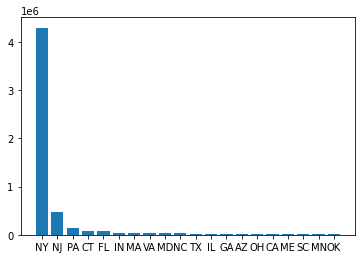

In [21]:
# visualize data
df = top_20_states.toPandas()
plt.bar(df['Registration State'], height=df['count'])

How often does each violation code occur? Display the frequency of the top five violation codes.

In [22]:
# get violation codes
violation_codes = [code['Violation Code'] for code in tickets_2017.select('Violation Code').distinct().collect()]

# we have 100 different violation codes in 2017
len(violation_codes)

100

In [23]:
# top 5 violation codes
violations = tickets_2017.select('Violation Code').groupBy('Violation Code').count().orderBy(desc('count')).limit(5)
violations.show()

+--------------+------+
|Violation Code| count|
+--------------+------+
|            21|768087|
|            36|662765|
|            38|542079|
|            14|476664|
|            20|319646|
+--------------+------+



Text(0.5, 1.0, 'Top 5 violation codes')

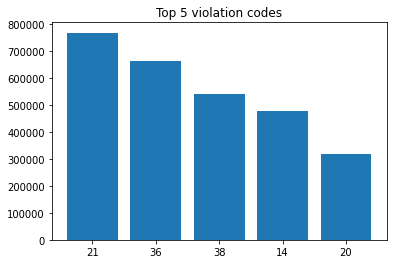

In [24]:
df = violations.toPandas()
plt.bar([str(code) for code in df['Violation Code']], df['count'])
plt.title('Top 5 violation codes')

How often does each 'vehicle body type' get a parking ticket? How about the 'vehicle make'? Find the top 5 for both.

In [25]:
# get top 5 vehicle body types
vehicle_body_type_by_tickets = tickets_2017.select('Vehicle Body Type').groupBy('Vehicle Body Type').count().orderBy(desc('count')).limit(5)
vehicle_body_type_by_tickets.show()

+-----------------+-------+
|Vehicle Body Type|  count|
+-----------------+-------+
|             SUBN|1883954|
|             4DSD|1547312|
|              VAN| 724029|
|             DELV| 358984|
|              SDN| 194197|
+-----------------+-------+



Text(0.5, 1.0, 'Top 5 vehicle body types')

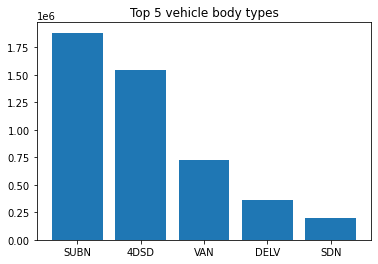

In [26]:
# visualize data
df = vehicle_body_type_by_tickets.toPandas()
plt.bar([tp for tp in df['Vehicle Body Type']], df['count'])
plt.title('Top 5 vehicle body types')

In [27]:
# get top 5 vehicle make
vehicle_make_by_tickets = tickets_2017.select('Vehicle Make').groupBy('Vehicle Make').count().orderBy(desc('count')).limit(5)
vehicle_make_by_tickets.show()

+------------+------+
|Vehicle Make| count|
+------------+------+
|        FORD|636844|
|       TOYOT|605291|
|       HONDA|538884|
|       NISSA|462017|
|       CHEVR|356032|
+------------+------+



Text(0.5, 1.0, 'Top 5 vehicle make')

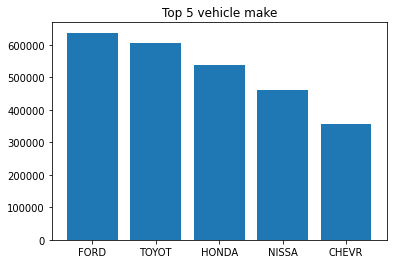

In [28]:
# visualize data
df = vehicle_make_by_tickets.toPandas()
plt.bar([v for v in df['Vehicle Make']], df['count'])
plt.title('Top 5 vehicle make')

### **Find some seasonality in this data**




divide the year into 4 seasons, and find the frequencies of tickets for each season and find the three most common violations for each of these seasons

In [29]:
tickets_season = tickets_2017.select(['Issue Date', 'Violation Code', 'Registration State']).cache()
tickets_season.show()

+-------------------+--------------+------------------+
|         Issue Date|Violation Code|Registration State|
+-------------------+--------------+------------------+
|2017-06-14 00:00:00|            47|                NY|
|2017-06-13 00:00:00|             7|                NY|
|2017-01-11 00:00:00|            78|                NY|
|2017-02-04 00:00:00|            40|                NY|
|2017-01-26 00:00:00|            64|                NY|
|2017-04-30 00:00:00|            20|                NY|
|2017-02-03 00:00:00|            36|                FL|
|2017-05-27 00:00:00|            38|                NY|
|2017-05-31 00:00:00|            14|                NY|
|2017-05-26 00:00:00|            75|                NY|
|2017-05-19 00:00:00|            10|                NY|
|2017-06-09 00:00:00|            69|                NY|
|2017-01-20 00:00:00|            21|                NJ|
|2017-04-13 00:00:00|            38|                NY|
|2017-01-05 00:00:00|            48|            

In [30]:
@udf(returnType=StringType())
def get_season(date):
  if date.month in [1, 2, 12]:
    return 'Winter'
  elif date.month in [3, 4, 5]:
    return 'Spring'
  elif date.month in [6, 7, 8]:
    return 'Summer'
  else:
    return 'Autumn'

In [31]:
tickets_season = tickets_season.withColumn('Seasons', get_season('Issue Date')).cache()
tickets_season.show()

+-------------------+--------------+------------------+-------+
|         Issue Date|Violation Code|Registration State|Seasons|
+-------------------+--------------+------------------+-------+
|2017-06-14 00:00:00|            47|                NY| Summer|
|2017-06-13 00:00:00|             7|                NY| Summer|
|2017-01-11 00:00:00|            78|                NY| Winter|
|2017-02-04 00:00:00|            40|                NY| Winter|
|2017-01-26 00:00:00|            64|                NY| Winter|
|2017-04-30 00:00:00|            20|                NY| Spring|
|2017-02-03 00:00:00|            36|                FL| Winter|
|2017-05-27 00:00:00|            38|                NY| Spring|
|2017-05-31 00:00:00|            14|                NY| Spring|
|2017-05-26 00:00:00|            75|                NY| Spring|
|2017-05-19 00:00:00|            10|                NY| Spring|
|2017-06-09 00:00:00|            69|                NY| Summer|
|2017-01-20 00:00:00|            21|    

In [32]:
# count all tickets and group by seasons

all_counts = tickets_season.select('Seasons').groupBy('Seasons').count()
all_counts.show()

+-------+-------+
|Seasons|  count|
+-------+-------+
| Spring|2873383|
| Summer| 852866|
| Winter|1704690|
| Autumn|    979|
+-------+-------+



<BarContainer object of 4 artists>

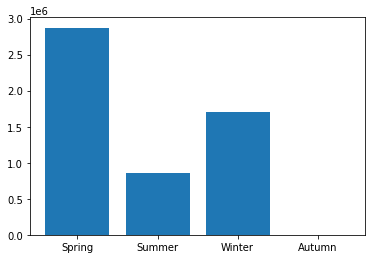

In [33]:
df = all_counts.toPandas()
plt.bar([str(season) for season in df['Seasons']], df['count'])

In [34]:
# top 3 most common violations for summer
# we get the following violation codes : 21, 36 and 38

tickets_season.select(['Violation Code', 'Seasons']).where(tickets_season['Seasons'] == 'Summer').groupBy('Violation Code').count().orderBy(desc('count')).limit(3).show()

+--------------+------+
|Violation Code| count|
+--------------+------+
|            21|127352|
|            36| 96663|
|            38| 83518|
+--------------+------+



In [35]:
# top 3 most common violations for winter 
# we get the following violation codes : 21, 36 and 38

tickets_season.select(['Violation Code', 'Seasons']).where(tickets_season['Seasons'] == 'Winter').groupBy('Violation Code').count().orderBy(desc('count')).limit(3).show()

+--------------+------+
|Violation Code| count|
+--------------+------+
|            21|238183|
|            36|221268|
|            38|187386|
+--------------+------+



In [36]:
# top 3 most common violations for spring
# we get the following violation codes : 21, 46, 40

tickets_season.select(['Violation Code', 'Seasons']).where(tickets_season['Seasons'] == 'Spring').groupBy('Violation Code').count().orderBy(desc('count')).limit(3).show()

+--------------+------+
|Violation Code| count|
+--------------+------+
|            21|402424|
|            36|344834|
|            38|271167|
+--------------+------+



In [37]:
# top 3 most common violations for autumn
# we get the following violation codes : 46, 40, 21

tickets_season.select(['Violation Code', 'Seasons']).where(tickets_season['Seasons'] == 'Autumn').groupBy('Violation Code').count().orderBy(desc('count')).limit(3).show()

+--------------+-----+
|Violation Code|count|
+--------------+-----+
|            46|  231|
|            21|  128|
|            40|  116|
+--------------+-----+



In [38]:
tickets_by_rank_seasons = tickets_season.select(['Violation Code', 'Seasons']).groupBy('Seasons', 'Violation Code').count().orderBy(desc('count'))

window = Window.partitionBy('Seasons').orderBy(desc('count'))
tickets_by_rank_seasons = tickets_by_rank_seasons.withColumn('Rank', rank().over(window)).orderBy(desc('count'))
tickets_by_rank_seasons.filter(tickets_by_rank_seasons['Rank'] < 4).orderBy('Seasons', 'Rank') \
  .select(['Seasons', 'Violation Code', 'count']).withColumnRenamed('count', 'Total Tickets').show()

+-------+--------------+-------------+
|Seasons|Violation Code|Total Tickets|
+-------+--------------+-------------+
| Autumn|            46|          231|
| Autumn|            21|          128|
| Autumn|            40|          116|
| Spring|            21|       402424|
| Spring|            36|       344834|
| Spring|            38|       271167|
| Summer|            21|       127352|
| Summer|            36|        96663|
| Summer|            38|        83518|
| Winter|            21|       238183|
| Winter|            36|       221268|
| Winter|            38|       187386|
+-------+--------------+-------------+



Find the total occurrences of the three most common violation codes.

In [39]:
# find total occurrences of the three most common violation codes
tickets_season.select(['Violation Code', 'Registration State']).groupBy('Violation Code').count().orderBy(desc('count')).limit(3).show()

+--------------+------+
|Violation Code| count|
+--------------+------+
|            21|768087|
|            36|662765|
|            38|542079|
+--------------+------+



The average fine of the top 3 Violation Codes are the following:

  - 21 : $65
   
  - 36 : $50

  - 38 : $50


In [40]:
# assign each violation code with its average fine
@udf(returnType=IntegerType())
def add_fine_by_code(code):
  if code == 21:
    return 65
  elif code == 36:
    return 50
  else:
    return 50

In [41]:
multiply_by_fine = udf(lambda code, count: count * 65 if code == 21 else (count * 50 if code == 36 else count * 50), IntegerType())

tickets_season.filter(tickets_season['Violation Code'].isin([21, 36, 38])) \
  .withColumn('Fine', add_fine_by_code('Violation Code')) \
  .groupBy('Violation Code').count() \
  .withColumn('Total Amount', multiply_by_fine('Violation Code', 'count')) \
  .withColumnRenamed('count', 'Total Tickets') \
  .orderBy(desc('Total Tickets')) \
  .show()

+--------------+-------------+------------+
|Violation Code|Total Tickets|Total Amount|
+--------------+-------------+------------+
|            21|       768087|    49925655|
|            36|       662765|    33138250|
|            38|       542079|    27103950|
+--------------+-------------+------------+



Find the top 3 states that have the highest ticket revenue based on the top 3 violation codes alone

In [42]:
tickets_season.select(['Registration State', 'Violation Code']) \
  .filter(tickets_season['Violation Code'].isin([21, 36, 38])) \
  .withColumn('Fine', add_fine_by_code('Violation Code')) \
  .groupBy('Registration State') \
  .sum('Fine').withColumnRenamed('sum(Fine)', 'Total Revenue') \
  .orderBy(desc('Total Revenue')) \
  .limit(3) \
  .show()

+------------------+-------------+
|Registration State|Total Revenue|
+------------------+-------------+
|                NY|     87901590|
|                NJ|      7368020|
|                PA|      3413995|
+------------------+-------------+



In [43]:
# spark.catalog.clearCache()

### **Conclusion**

From the results above, I can infer the following assumptions:



1. The top 5 states which have the highest violation ticket rate are : 
New York, New Jersey, Pennsylvania, Connecticut and Florida respectively. New York has 4,290,006 violation tickets recorded.

2. Top 5 vehicle brands are FORD, TOYOTA, HONDA, NISSAN and CHEVROLET

3. Spring and Winter have significant amount of ciolation ticket rate

4. Top 3 violation codes are 21, 36 and 38. There is code 21 in every season.
  I guess this violation code is the most code people always violate.
  Code 21 means that people park their vehicle at a place which is not allowed to park.

5. Code 36 is the second out of the top 3 violation codes. This means that people drive faster than the posted speed limit and use speed near a school zone

6. Code 38 is the third one of the top 3 violation codes. It means that many people fail to show their receipt or tag in the windshield

7. Most people always violate these 3 codes. This is the reason why each state can gain revenue so much based on these 3 codes.

8. New York, New Jersey and Pennsylvania are the top 3 states which can gain so much revenue.

9. New York gains the most outstanding amount of revenue out of all states. It may be because New York is the most crowded state and has significant quantity of vehicles.

